In [1064]:
import json

import agama
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore

Lets look at disk shocking

In [ ]:
sim = "m12i"

data_dir = "/Users/z5114326/Documents/GitHub/gc_statistics/data/"
data_file = data_dir + "m12i_time_dep.json"

sim_dir = "/Users/z5114326/Documents/simulations/"
pot_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/potentials/"
potential_snaps = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/external/potentials.json"

fire_dir = sim_dir + sim + "/" + sim + "_res7100/"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

pub_data = sim_dir + "snapshot_times_public.txt"

# 1. set units (in Msun, Kpc, km/s)
agama.setUnits(mass=1, length=1, velocity=1)

with open(data_file, "r") as file:
    data_dict = json.load(file)

with open(potential_snaps) as json_file:
    pot_data = json.load(json_file)

snap_time_pub = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
snap_time_pub.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

res_df = snap_time_pub[snap_time_pub["index"].isin(pot_data[sim])].reset_index(drop=True)

In [1066]:
def get_pot_dict(df, t_init, t_final):
    pot_dict = {}
    if len(df) > 1:
        pot_dict[df["index"][0]] = {}
        pot_dict[df["index"][0]]["t0"] = t_init

        pot_dict[df["index"][0]]["t1"] = np.max([df["time_Gyr"][0], t_init])

        t_hold = df["time_Gyr"][0] + (df["time_Gyr"][1] - df["time_Gyr"][0]) / 2
        pot_dict[df["index"][0]]["t2"] = t_hold

        for i in range(2, len(df["time_Gyr"])):
            pot_dict[df["index"][i - 1]] = {}

            t_past = df["time_Gyr"][i - 1]
            t_futu = df["time_Gyr"][i]

            t_hold = t_past + (t_futu - t_past) / 2

            pot_dict[df["index"][i - 1]]["t0"] = pot_dict[df["index"][i - 2]]["t2"]
            pot_dict[df["index"][i - 1]]["t1"] = df["time_Gyr"][i - 1]
            pot_dict[df["index"][i - 1]]["t2"] = t_hold

        pot_dict[df["index"].iloc[-1]] = {}

        t0 = pot_dict[df["index"].iloc[-2]]["t2"]
        pot_dict[df["index"].iloc[-1]]["t0"] = t0
        pot_dict[df["index"].iloc[-1]]["t1"] = np.min([df["time_Gyr"].iloc[-1], t_final])
        pot_dict[df["index"].iloc[-1]]["t2"] = t_final

    else:
        pot_dict[df["index"][0]] = {}
        pot_dict[df["index"][0]]["t0"] = t_init

        pot_dict[df["index"][0]]["t1"] = (t_init + t_final) / 2

        pot_dict[df["index"][0]]["t2"] = t_final

    return pot_dict

In [1067]:
# find nearest
def propagate(init_cond, t_prop_from, t_prop_to, t_step, pot_nbody):
    dt = t_prop_to - t_prop_from

    # Floor ensures step size ≤ t_step
    num_steps = max(int(np.abs(np.floor(dt / t_step))), 1) + 1
    # num_steps = 1000

    time, posvel = agama.orbit(potential=pot_nbody, ic=init_cond, time=dt, trajsize=num_steps)

    time = t_prop_from + time

    return time, posvel


In [1084]:
def propagate_group_orbits(it, group_id, t_step=0.05):
    it_id = iteration_name(it)

    src_data = proc_data[it_id]["source"]
    mask = np.array(src_data["analyse_flag"]) == 1

    idx_lst = np.where(np.array(src_data["group_id"][mask] == group_id))[0]
    gc_id_lst = src_data["gc_id"][mask][idx_lst]

    prop_dict = {}
    for gc_id, idx in zip(gc_id_lst, idx_lst):
        prop_dict[gc_id] = {}

        if group_id == 0:
            t_init = src_data["form_time"][mask][idx]
        else:
            t_init = src_data["t_acc"][mask][idx]

        t_early = res_df["time_Gyr"].iloc[0]

        if t_init < t_early:
            t_init = t_early

        t_final = src_data["t_dis"][mask][idx]
        t_late = res_df["time_Gyr"].iloc[-1]

        if t_final == -1:
            t_final = t_late

        ####################################################################################

        t_list = res_df["time_Gyr"]

        tim_start = res_df["time_Gyr"][(t_list - t_init).abs().idxmin()]
        if tim_start < t_init:
            pot_start = res_df["index"][(t_list - t_init).abs().idxmin() + 1]
        else:
            pot_start = res_df["index"][(t_list - t_init).abs().idxmin()]

        tim_end = res_df["time_Gyr"][(t_list - t_final).abs().idxmin()]
        if tim_end > t_final:
            pot_end = res_df["index"][(t_list - t_final).abs().idxmin() - 1]
        else:
            pot_end = res_df["index"][(t_list - t_final).abs().idxmin()]

            # need to check for the time issue in the GC model output
            snap_id = snapshot_name(pot_end)
            idx_check = np.where(np.array(proc_data["it000"]["snapshots"][snap_id]["gc_id"]) == gc_id)[0]
            if len(idx_check) == 0:
                pot_end = res_df["index"][(t_list - t_final).abs().idxmin() - 1]

        # t_start = filtered_df["time_Gyr"][idx_start]

        df = res_df[(res_df["index"] >= pot_start) & (res_df["index"] <= pot_end)].reset_index(drop=True)

        # if gc_id only exists between snapshots
        if len(df) == 0:
            continue

        pot_dict = get_pot_dict(df, t_init, t_final)

        ####################################################################################

        time_arr = np.array([])
        posvel_arr = np.empty((0, 6))  # 2D with 6 columns (same as posvel)

        for snap in pot_dict:
            potential_file = pot_dir + sim + "/snap_%d/combined_snap_%d.ini" % (snap, snap)
            pot_nbody = agama.Potential(potential_file)

            t0 = pot_dict[snap]["t0"]
            t1 = pot_dict[snap]["t1"]
            t2 = pot_dict[snap]["t2"]

            snap_id = snapshot_name(snap)
            # print(gc_id, snap_id)
            snap_data = proc_data[it_id]["snapshots"][snap_id]

            idx = np.where(np.array(snap_data["gc_id"]) == gc_id)[0][0]

            x = snap_data["x"][idx]
            y = snap_data["y"][idx]
            z = snap_data["z"][idx]

            vx = snap_data["vx"][idx]
            vy = snap_data["vy"][idx]
            vz = snap_data["vz"][idx]

            init_cond = [x, y, z, vx, vy, vz]

            # propagate backwards
            time, posvel = propagate(init_cond, t1, t0, t_step, pot_nbody)

            # Get sorted indices
            sorted_indices = np.argsort(time)

            # sort by ascending order
            time = time[sorted_indices]
            posvel = posvel[sorted_indices]

            # stack arrays
            if snap == df["index"][0]:
                time_arr = np.concatenate((time_arr, time))
                posvel_arr = np.vstack((posvel_arr, posvel))
            else:
                time_arr = np.concatenate((time_arr, time[1:]))
                posvel_arr = np.vstack((posvel_arr, posvel[1:]))

            # propagate forwards
            time, posvel = propagate(init_cond, t1, t2, t_step, pot_nbody)

            # stack arrays (don't include first inputs as repetition)
            time_arr = np.concatenate((time_arr, time[1:]))
            posvel_arr = np.vstack((posvel_arr, posvel[1:]))

        prop_dict[gc_id]["time"] = time_arr
        prop_dict[gc_id]["posvel"] = posvel_arr

    return prop_dict

In [1083]:
prop_dict_1920378 = propagate_group_orbits(0, 1920378)


35285838 snap142
35286914 snap142
35286914 snap172
38843341 snap142
38843341 snap172
35673043 snap142
35673043 snap172
35673043 snap214
39442910 snap142
39442910 snap172
37458283 snap142
36863836 snap142
40834851 snap142
40834851 snap172
36081620 snap142
36081620 snap172
104626395 snap142
104626395 snap172
104626395 snap214
104626395 snap277
104626395 snap294
104626395 snap312
104626395 snap332
104626395 snap356
104626395 snap382
104626395 snap412
105213549 snap142
106981623 snap142
106981623 snap172
106981623 snap214
106981623 snap277
106981623 snap294
108168557 snap142
108168557 snap172
108168557 snap214
108168557 snap277
108168557 snap294
107176249 snap142
107176249 snap172
108168551 snap142
108168551 snap172
36464699 snap142
36464699 snap172
40438430 snap142
36472687 snap142
36472687 snap172
36472687 snap214
36472687 snap277
31975248 snap142
37071108 snap142
36661444 snap142
36661444 snap172
36661444 snap214
36661444 snap277
38246924 snap142
38246924 snap172
34302462 snap142
343024

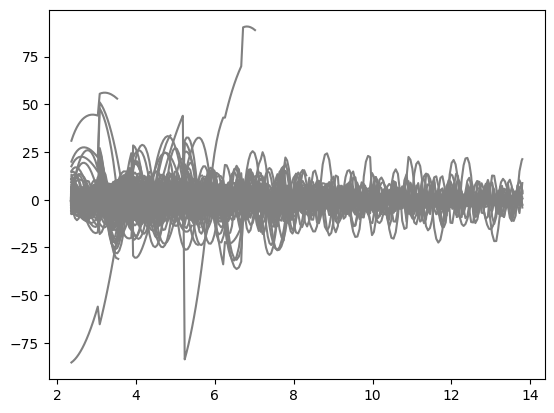

In [1098]:
for gc_id in prop_dict_1920378.keys():
    if "time" not in prop_dict_1920378[gc_id]:
        continue
    else:
        time = prop_dict_1920378[gc_id]["time"]

    posvel = prop_dict_1920378[gc_id]["posvel"]
    z = posvel[:, 2]

    plt.plot(time, z, c="grey")

71

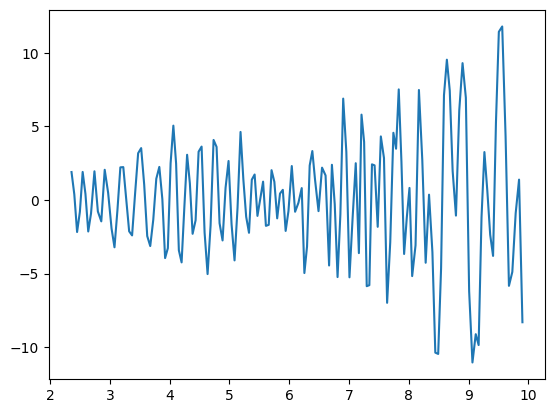

In [ ]:
plt.plot(t, z)

# number of crossing
len(np.where(np.diff(np.sign(z)) != 0)[0])

In [1132]:
time_steps = res_df["time_Gyr"].to_list()
snap_lst = res_df["index"].to_list()

it = 0
gc_id = 104626395


it_id = iteration_name(it)

n_cross_lst = []

t = prop_dict_1920378[gc_id]["time"]
z = prop_dict_1920378[gc_id]["posvel"][:, 2]

for time_step, snap in zip(time_steps, snap_lst):
    snap_id = snapshot_name(snap)
    snap_dat = proc_data[it_id]["snapshots"][snap_id]

    idx = np.where(np.array(snap_dat["gc_id"]) == gc_id)[0]
    if len(idx) == 0:
        print(snap_id)
        n_cross_lst.append(np.nan)
        continue
    else:
        idx = idx[0]

    mask = t < time_step
    z_step = z[mask]
    n_cross = len(np.where(np.diff(np.sign(z_step)) != 0)[0])
    n_cross_lst.append(n_cross)

snap046
snap446
snap486
snap534
snap590
snap591
snap592
snap593
snap594
snap595
snap596
snap597
snap598
snap599
snap600


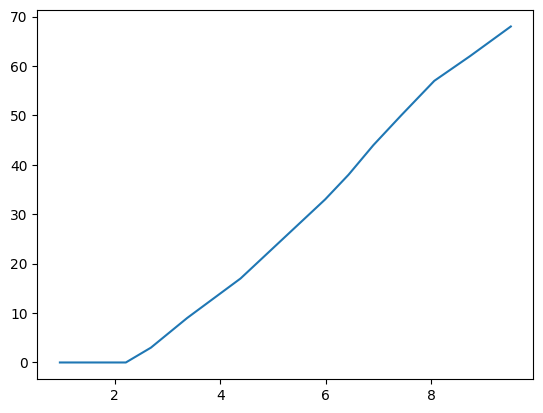

In [1129]:
plt.plot(time_steps, n_cross_lst)

In [1131]:
t

array([2.35899997, 2.40561104, 2.45222187, 2.49883294, 2.54544401,
       2.59205508, 2.63866591, 2.68527699, 2.74252748, 2.79977798,
       2.85702848, 2.91427922, 2.97152972, 3.02878022, 3.07785201,
       3.12692404, 3.17599583, 3.22506785, 3.27413964, 3.32321167,
       3.37228346, 3.42290306, 3.4735229 , 3.5241425 , 3.57476211,
       3.62538195, 3.67600155, 3.72662115, 3.77724075, 3.82786059,
       3.8784802 , 3.92449808, 3.97051597, 4.01653385, 4.0625515 ,
       4.10856962, 4.15458727, 4.20060539, 4.24662304, 4.29264116,
       4.33865881, 4.38467693, 4.43478537, 4.4848938 , 4.53500175,
       4.58511019, 4.63521862, 4.68532705, 4.73543549, 4.78554344,
       4.83565187, 4.88576031, 4.93586874, 4.98597717, 5.03608513,
       5.08619356, 5.13630199, 5.18641043, 5.23357105, 5.28073168,
       5.3278923 , 5.37505341, 5.42221403, 5.46937466, 5.51653576,
       5.56369638, 5.61085701, 5.65801811, 5.70517874, 5.75233936,
       5.79950047, 5.84666109, 5.89382172, 5.94098282, 5.98814